## Read Data Functions

In [143]:
#Import 
from tracemalloc import Statistic
import nltk,re,pandas as pd,random,numpy as np
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import seaborn as sns
import nltk
try:
  nltk.data.find('corpora/wordnet') # ????/wordnet
except LookupError:
  nltk.download('wordnet')

try:
  nltk.data.find('corpora/gutenberg') # ????/wordnet
except LookupError:
  nltk.download('gutenberg')

try:
  nltk.data.find('corpora/stopwords') # ????/wordnet
except LookupError:
  nltk.download('stopwords')

try:
  nltk.data.find('corpora/omw-1.4') # ????/wordnet
except LookupError:
  nltk.download('omw-1.4')

  
try:
  nltk.data.find('corpora/punkt') # ????/wordnet
except LookupError:
  nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [144]:
class TextDataPartitioning:  # Create Class to generalize the program

    Partitioning_DataFrame2 = pd.DataFrame()
    
    def ReadBooks(Book_Name):  # This function will take Book_Name as parameter for example: austen-emma.txt
        return nltk.corpus.gutenberg.raw(Book_Name)  # Convert NLTK books to string datatype
    
    def GetTitle(Book_Name):  # This function will take Book_Name as parameter for example: austen-emma.txt
        Book = TextDataPartitioning.ReadBooks(Book_Name)  # Call ReadBooks function
        TextDataPartitioning.Book_Title = re.findall('^\[(.*)\]', Book)  # Use re.findall to extract and assign the title of the book to list datatype variable
        TextDataPartitioning.Book_Title = TextDataPartitioning.Book_Title[0] # Convert list datatype to string datatype
        return TextDataPartitioning.Book_Title # Return book title as string datatype
    
    def BookPreProcessing(Book_Name):   # This function will take Book_Name as parameter for example: austen-emma.txt
        Book = TextDataPartitioning.ReadBooks(Book_Name)  # Call ReadBooks function
        TextDataPartitioning.Book_Title = '[' + TextDataPartitioning.Book_Title + ']'  # Add [] to the book title to be able to remove it with the square brackets from the book
        Book = Book.replace(TextDataPartitioning.Book_Title,'')  # Remove book title from the book
        Book = re.sub('(CHAPTER(.*))|(Chapter(.*))', '', Book)  # Remove chapter title from the book
        Book = re.sub('(VOLUME(.*))|(Volume(.*))', '', Book)  # Remove Volume title from the book  
        Book = re.sub('^$\n', '', Book, flags = re.MULTILINE)  # Remove empty lines
        Book = re.sub('\. *(\W)','.\n\n', Book)  # Create a new line after each fullstop
        Book = re.sub('[^\w\s]','', Book)  # Remove punctuation marks from the book
        Book = re.sub(r'\b\w{1,2}\b', '',Book)
        Book = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', '', Book)
        Book = re.sub("[^a-zA-Z]", " ",Book)
        Book = Book.lower()  # Convert the book to small text
        Book = Book.split()  # Convert the book to list datatype
        StopWords = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        ps = PorterStemmer()

        Book = [ ps.stem( lemmatizer.lemmatize(word)) for word in Book if not word in StopWords]  # Remove stopwords from this list
        return Book  # Return the book list datatype

    def BookPartitioning(Text):
        PhargraphList=[]
        TextLen= len(Text)
        
        
        NumberOfParagraph = TextLen // 150
        
        for i in range(1,NumberOfParagraph):
            startIndex = i*150 - 150
            endIndex = (i-1)*150+150
            
            if(endIndex >= len(Text)):
                endIndex = len(Text) - endIndex
            
            PhargraphList.append(Text[startIndex : endIndex])
        return PhargraphList
 

    def CreateDataFrame1(Partitions_list, Book_Title):
        DFparagraphs = pd.DataFrame(columns =["paragraph","Authors"])
     
        random.seed(41)
        #choose 200 random paragaph from all paragaphs
        Partitions_list=random.choices(Partitions_list, k=200)
        
        data = {'paragraph':Partitions_list,'Authors':Book_Title}
        
        DFparagraphs = DFparagraphs.append( pd.DataFrame(data))

        return DFparagraphs


    def ConvertToString(DataFrame):
        for i in range(len(DataFrame)):
            DataFrame.iloc[i,0] = ' '.join([str(element) for element in DataFrame.iloc[i,0]])
        return DataFrame
    
    
    def Plot_Commaon_words(Paragaphs, Book_title,N_gram):
        parag=" ".join(Paragaphs)
        lst_tokens = nltk.tokenize.word_tokenize(parag)
        List = []
        for i in range(1,N_gram+1):
            dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, i))
            dtf_uni = pd.DataFrame(dic_words_freq.most_common(),  columns=["Word","Freq"])
            dtf_uni.sort_values(by="Freq" ,inplace=True ,ascending=False )
            dtf_uni.iloc[0:15 , :  ].set_index("Word").plot(kind="barh", title= f" {Book_title}",legend=False, color ='#940101').grid(axis='x')
            List.append(dtf_uni)
            plt.xlabel('Words Frequancy')

            plt.show()
        return List


    @staticmethod
    def GetBooks():
        ListOfBooks = ['bible-kjv.txt','austen-emma.txt','carroll-alice.txt','chesterton-thursday.txt','whitman-leaves.txt']
        Authors = ['bible', 'Jane Austen', 'Carroll Lewis','G. K. Chesterton','Walt Whitman']
        DFparagraphs = pd.DataFrame(columns =["paragraph","Authors"])

        Book_Title = [None] * 5
        Book = [None] * 5
        Partitions = [None] * 5
        for i in range(5):
            
            Book_Title[i] = TextDataPartitioning.GetTitle(ListOfBooks[i])
            
            Book[i] = TextDataPartitioning.BookPreProcessing(ListOfBooks[i])
            
            Partitions[i] = TextDataPartitioning.BookPartitioning(Book[i])
            
            DFparagraphs=  DFparagraphs.append( TextDataPartitioning.CreateDataFrame1(Partitions[i], Authors[i]))
            

        del Partitions


        return TextDataPartitioning.ConvertToString(DFparagraphs)

    @staticmethod
    def PotCommonWords(DFparagraphs):
        Authers = DFparagraphs["Authors"].unique()

        for Auther in Authers:
            Paragaphs = DFparagraphs[DFparagraphs["Authors"] ==Auther ]["paragraph"]
            TextDataPartitioning.Plot_Commaon_words(Paragaphs, Auther,1)


# Books = TextDataPartitioning.GetBooks()
# TextDataPartitioning.PotCommonWords(Books)

<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:21: DeprecationWarning: invalid escape sequence \.
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:21: DeprecationWarning: invalid escape sequence \.
<input>:22: DeprecationWarning: invalid escape sequence \w
<input>:10: DeprecationWarning: invalid escape sequence \[
<input>:21: DeprecationWarning: invalid escape sequence 

## Preprocessing Functions

In [145]:
import nltk,re,pandas as pd,random,numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [199]:
class TrasForm:
    
    @staticmethod
    def LabelEncoder(Labels):
        le = preprocessing.LabelEncoder()
        Result = le.fit_transform(Labels)
        return Result
    
    
    def BoW_Encoder(Paragaphs):
        
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(Paragaphs)
        return X , vectorizer
    
    def TFIDF_Encoder(Paragaphs):
        
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(Paragaphs)
        return X , vectorizer
    
    def TFIDF_NGram_Encoder(Paragaphs , start_Ngram , End_Ngram):
        
        vectorizer = TfidfVectorizer(ngram_range=(start_Ngram,End_Ngram))
        X = vectorizer.fit_transform(Paragaphs)
        return X , vectorizer

    @staticmethod
    def W2V_Encoder(X):
       import gensim
       from gensim.models import Word2Vec

       # Create CBOW model
       X_words = [i.split(' ') for i in X]
       model1 = gensim.models.Word2Vec(min_count = 1, size = 1000, window=5, workers=4)
       model1.build_vocab(X_words, progress_per=1000)
       model1.train(X_words, total_examples=model1.corpus_count, epochs=30, report_delay=1)
       model1.init_sims(replace=True)
       model1.save("word2vec.model1")


       myset =  []
       for i in range(len(X_words)):
           myset.append(set(X_words[i]))
           myset[i] = list(myset[i])
           
           
       Unique_Words = []
       for i in range(len(myset)):
           Unique_Words = Unique_Words + myset[i]
       Unique_Words = sorted(list(set(Unique_Words)))


       X_word2Vec = []
       for i in range(len(Unique_Words)):
           X_word2Vec.append(model1.wv.__getitem__(Unique_Words[i]))
       X_word2Vec = np.array(X_word2Vec).T
       return X_word2Vec

    
    @staticmethod
    def SVD(XTrain,n):
        SVD = TruncatedSVD(n_components = n,random_state=1)
        XTrain = SVD.fit_transform(XTrain)
        return XTrain ,SVD
    
    @staticmethod
    def Test_Best_PCA_com(X,Test_Range,Test_Inrease,plt_title):
        
        List_Variance = [] 
        Tests=[ x*Test_Inrease for x in Test_Range ]
        for i in Tests:
            print(i)
            SVD  =  TruncatedSVD(n_components=i, random_state=42)
            X_trainBOW_SVD= SVD.fit_transform(X)
            var_explained = SVD.explained_variance_ratio_.sum()
            List_Variance.append(var_explained)
        plt.plot( Tests ,List_Variance, linewidth=2)
        plt.title(f'Scree Plot ({plt_title}) Transform')
        plt.xlabel('Principal Component')
        plt.ylabel('Proportion of Variance Explained')
        plt.show()
            
   
    @staticmethod
    def TransForm(Type , Paragaphs ,  start_Ngram , End_Ngram):
        
        if(Type=="BOW"):
            return TrasForm.BoW_Encoder(Paragaphs)
        
        elif(Type=="TF_IDF"):
            return TrasForm.TFIDF_Encoder(Paragaphs)
        
        elif(Type=="TFIDF_NGram"):
            return TrasForm.TFIDF_NGram_Encoder(Paragaphs ,  start_Ngram , End_Ngram)
        
        elif(Type=="W2V_Encoder"):
            return TrasForm.W2V_Encoder(Paragaphs)

##  Visualize Functions

Function implement T-sne to plot Data

In [150]:
def Visulaize_Data(X,Labels ,Title):  
    from sklearn.manifold import TSNE
    tfs_embedded = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(X)
    sns.scatterplot(x=tfs_embedded[:, 0], y=tfs_embedded[:, 1],hue=Labels )
    plt.title(Title)
    plt.show()

Visualize wrong Data point

In [151]:
def Visulaize_Data_With_WrongPoints(X,Labels ,TrueLabels,Title):  
    from sklearn.manifold import TSNE
    tfs_embedded = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(X)
    flasePoint = np.where(Labels != TrueLabels)
    sns.scatterplot(x=tfs_embedded[:, 0], y=tfs_embedded[:, 1],s=80, hue=Labels )
    sns.scatterplot(x=tfs_embedded[flasePoint][:, 0], y=tfs_embedded[flasePoint][:, 1], marker ='X', s=30, color='red' )
    plt.title(Title)
    plt.show()

Impelemnt Words Word Cloud

In [152]:
from wordcloud import WordCloud 

def Word_Cloud(corpus,title):
    wc = WordCloud(background_color='white', max_words=100, 
                         max_font_size=35, colormap='Reds')
    wc = wc.generate(str(corpus))
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.title(title)
    plt.show()

# Read Data

In [153]:
Books =TextDataPartitioning.GetBooks()
Books = Books.sample(frac=1,random_state=2).reset_index(drop=True)
Y =TrasForm.LabelEncoder(Books["Authors"]) 

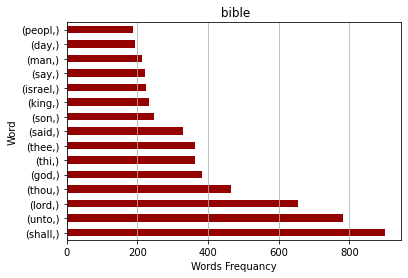

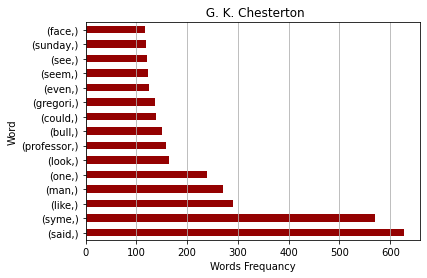

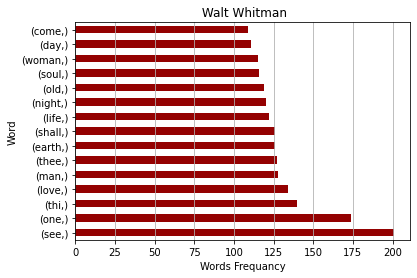

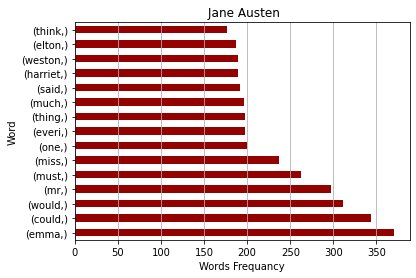

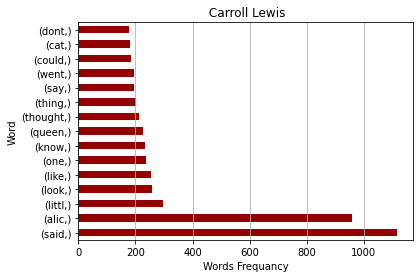

In [154]:
TextDataPartitioning.PotCommonWords(Books)

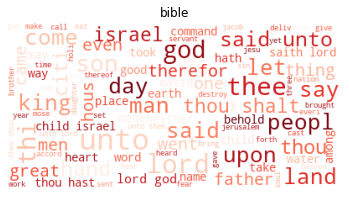

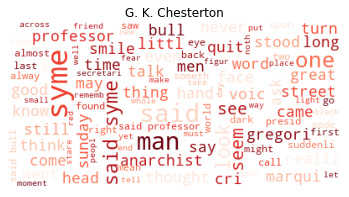

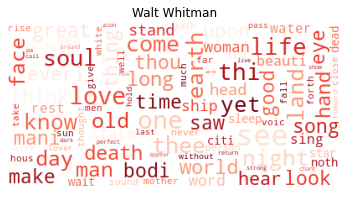

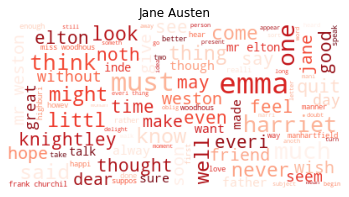

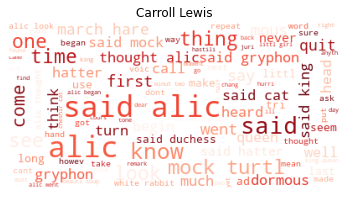

In [155]:
for book  in Books["Authors"].unique():
  Word_Cloud(' '.join( Books.loc[Books["Authors"]==book,'paragraph']),book)

# Text Vectorization

In [200]:
# TRansform Your Featrues
X_Bow , Transformer_Bow =  TrasForm.TransForm("BOW",Books["paragraph"],0,0)

# TF_IDF
X_Tf_IDF , Transformer_TDIDF =  TrasForm.TransForm("TF_IDF",Books["paragraph"],0,0)

# TF_IDF 2_Gram
X_2Gram , Transformer_Bow =  TrasForm.TransForm("TFIDF_NGram",Books["paragraph"],2,2)

#Word2Vec
word2vec = TrasForm.TransForm("W2V_Encoder",Books["paragraph"],0,0)


/usr/local/lib/python3.7/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/

## LDA

In [157]:
import gensim
from gensim import corpora

def lda_training(data ,n_topics):
  docs=[]
  for i in data :
    docs.append(i.split())

  dictionary = corpora.Dictionary(docs)
  bow = [dictionary.doc2bow(partition) for partition in docs]  # bag of words for each partition
  example = pd.DataFrame(bow[10], columns=["token_id", "frequency"])

  lda_model = gensim.models.LdaModel(bow,
               id2word = dictionary,
               num_topics = n_topics,
               random_state = 100,
               passes = 50,
               iterations = 500, 
               chunksize = 100
               )
  coherence_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts= docs , dictionary=dictionary , coherence='c_v')
  coherence_lda = coherence_lda.get_coherence()
  # print('\nCoherence Score: ', coherence_lda)
  # print(lda_model.print_topics())
  return lda_model , bow , coherence_lda

In [158]:
LDA_model , corpus , coherence_lda = lda_training(Books["paragraph"],n_topics = 5)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [159]:
coherence_lda

0.5109381617623039

In [160]:
def feature_vectorize(lda ,corpus):
  # Convert target column from string to numbers 
  Books.Authors = pd.Categorical(Books.Authors)
  Books['Authors'] = Books.Authors.cat.codes
    
  train_vecs = []
  for i in range(len(Books['paragraph'])):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability = 0.0)
    topic_vec = [top_topics[i][1] for i in range(len(lda.print_topics()))]
    train_vecs.append(topic_vec)

  features = pd.DataFrame(train_vecs)
  lda_data = features.join(Books["Authors"])#.sample(frac = 1)

  lda_x = lda_data[lda_data.columns[:-1]]
  lda_y = pd.DataFrame(lda_data[lda_data.columns[-1]])
  return lda_data, lda_x, lda_y

In [161]:
lda_data, lda_x, lda_y = feature_vectorize(LDA_model ,corpus)

In [162]:
%pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
visaul = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary=LDA_model.id2word)
visaul

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.184086  0.031204       1        1  35.402619
2     -0.161955  0.080913       2        1  23.571249
3      0.003979 -0.200631       3        1  21.139874
1      0.153799 -0.086543       4        1  11.344799
0      0.188263  0.175058       5        1   8.541460, topic_info=       Term         Freq        Total Category  logprob  loglift
971    unto   745.000000   745.000000  Default  30.0000  30.0000
74    shall  1148.000000  1148.000000  Default  29.0000  29.0000
47     lord   622.000000   622.000000  Default  28.0000  28.0000
1044   alic   926.000000   926.000000  Default  27.0000  27.0000
189    said  2197.000000  2197.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
56      one    48.446378   942.576717   Topic5  -5.5777  -0.5079
120    come    43.552788   664.964942   Topic5  -5.6842  -0.2655
300     old    41.056248   266.366403   Topic5  -5.7432   0.5903
168    like    40.630295   762.117893   Topic5  -5.7536  -0.4713
290    love    39.530526   235.598117   Topic5  -5.7811   0.6752

[344 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2159      3  0.989802  accord
1044      1  0.999051    alic
1457      1  0.178011    also
1457      2  0.057592    also
1457      3  0.701572    also
...     ...       ...     ...
881       5  0.091593     yet
344       2  0.621307   young
344       3  0.104468   young
344       4  0.269417   young
2506      1  0.988371    your

[558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

## PCA  TF_IDF , BOW ,Word2Vec

 Check Best number of PCA components 
 Plot Scree Plot

100


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

200


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

300


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

400


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

500


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

600


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

700


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

800


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

900


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

1000


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

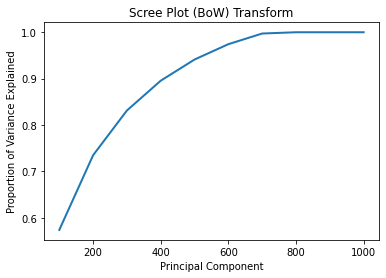

In [164]:
#BOW
TrasForm.Test_Best_PCA_com(X_Bow,[x for x in range(1,11)],100,"BoW")


In [165]:
X_SVD_Bow , Bow_SVD = TrasForm.SVD(X_Bow,700)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

100


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

200


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

300


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

400


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

500


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

600


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

700


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

800


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

900


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

1000


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

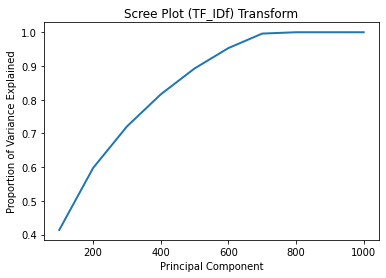

In [166]:
#Tf_idf
TrasForm.Test_Best_PCA_com(X_Tf_IDF,[x for x in range(1,11)],100,"TF_IDf")

In [167]:
X_SVD_Tf_idf  ,TF_idf_SVD  = TrasForm.SVD(X_Tf_IDF,700)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [168]:
#2Gram
# TrasForm.Test_Best_PCA_com(X_2Gram,[x for x in range(1,11)],100,"2Gram")

In [169]:
# X_SVD_2Gram , Gram2_SVD = TrasForm.SVD(X_2Gram,700)

100


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

200


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

300


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

400


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

500


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

600


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

700


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

800


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

900


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

1000


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

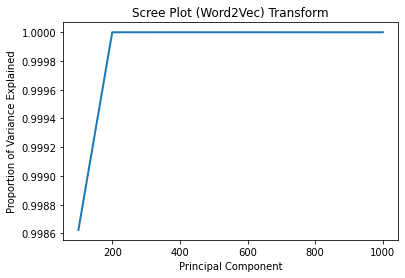

In [170]:
#Word2Vec
TrasForm.Test_Best_PCA_com(word2vec,[x for x in range(1,11)],100,"Word2Vec")

In [171]:
# X_SVD_Word2Vec , Word2Vec_SVD = TrasForm.SVD(Word2Vec,700)

## Visualize Transformed Data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.078s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.591s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.511s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.503s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.470s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.481s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.393s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004

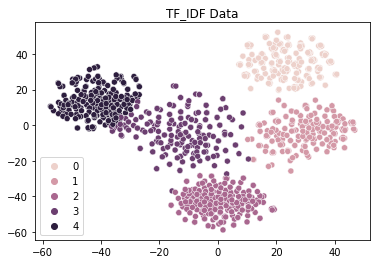

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.082s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.576s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.514s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.492s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.476s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.488s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.400s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004

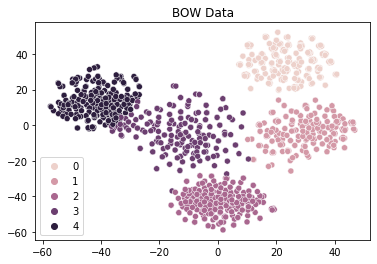

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.082s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.554s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.512s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.475s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.489s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.495s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.398s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004

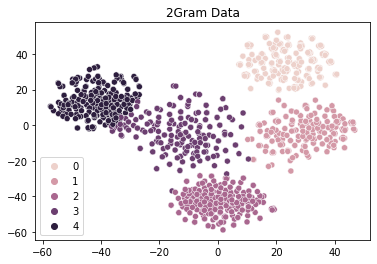

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.556s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.511s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.495s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.483s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.471s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.411s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004

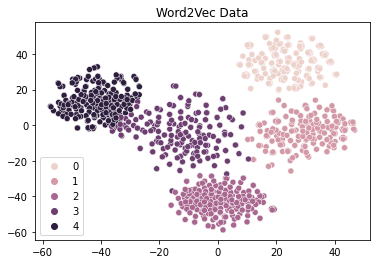

In [172]:

Visulaize_Data(X_Tf_IDF,Y,"TF_IDF Data")

Visulaize_Data(X_Tf_IDF,Y,"BOW Data")

Visulaize_Data(X_Tf_IDF,Y,"2Gram Data")

Visulaize_Data(X_Tf_IDF,Y,"Word2Vec Data")

# Metric Functions

In [173]:
#Import
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.cluster import AgglomerativeClustering
import wordcloud

In [174]:
def silhouette_Scores(X ,labels ):
       return silhouette_score(X, labels , metric='cosine')

In [175]:
def Test_Models(X, labels,Culter_Labels):
    print('-------------------------------------')
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, Culter_Labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels,Culter_Labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels,Culter_Labels))
    print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, Culter_Labels))
    print("Silhouette Coefficient: %0.3f"  % metrics.silhouette_score(X, Culter_Labels,metric='cosine'))
    print("Kappa: %.3f" % cohen_kappa_score(labels, Culter_Labels))
    print('-------------------------------------')



# Error Analysis Functions

In [176]:
def ReName_Clusters(Labels,True_Labels):
    numberOFclusers =len(np.unique(Labels))
    
    TrueBooks = np.zeros_like(Labels)
    # Key Book
    #Vale claster
    Dic= {}
    
    for clusterNum in range(0,numberOFclusers):
        
        all_DataPoint_In_Cluster  = np.where(Labels == clusterNum)
        
        vals, counts = np.unique( True_Labels[all_DataPoint_In_Cluster] , return_counts=True)
        print(np.unique( True_Labels[all_DataPoint_In_Cluster] , return_counts=True))
        mode_value = vals[np.argwhere(counts == np.max(counts))[0][0]]
        Dic[mode_value] = clusterNum       
        for data_point in all_DataPoint_In_Cluster:
            
            TrueBooks[data_point]=int(mode_value)
    return TrueBooks ,Dic

In [177]:
def Error_any(Data ,Transformer , Labels , TrueLabels):
    from collections import Counter
    
    #Get All Wrong clustring point 
    WrongPoints = Data[ Labels != TrueLabels] 
    
    NumnerOFWrong = WrongPoints.shape[0]
    print(f"Number of Wrong points {NumnerOFWrong}")
    
    #Inverse Transform All paragapth into text again
    All_Wrong_String = []
    for DataPoint in WrongPoints:
        str_centers = ' '.join(Transformer.inverse_transform(DataPoint.reshape(1,-1))[0].tolist())
        All_Wrong_String.append(str_centers)
    
    #Get the most 10 frequent words in all wrong clustres
    MostCommon10 =  Counter(' '.join(All_Wrong_String).split()).most_common(10)

    #create df to append results on it and use for ploting
    df = pd.DataFrame(columns=['Book','word','count'])

    # for each word in most 10 common words in wrong clusters 
    # get the count of the frequent of this word in 5 books
    for Word in MostCommon10:
        Authors =  Books['Authors'].unique()
       
        for Auther in Authors:
                count = ' '.join(Books.loc[Books['Authors']==Auther , 'paragraph']).count(Word[0])
                WordCount = {'Book':Auther , 'word':Word[0] , 'count':count }
                df_dictionary = pd.DataFrame([WordCount])
                df = pd.concat([df,df_dictionary],ignore_index=True)
     

    sns.barplot(x='word', y='count' , hue="Book" , data=df )
    plt.show()

# KMeans Model

In [178]:
def Kmeans(X,K):
    km = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=50,verbose=1 ,random_state=1)
    km.fit(X)
    return km

In [179]:
def Choose_Best_K(Data,k_start , k_end  , figsize1 = 10 , figsize2 = 5 ):  
  wcss = []
  silhouette_scores = []
  for k in range(k_start,k_end):
      kmeanModel =Kmeans(Data,k)
      wcss.append(kmeanModel.inertia_)
      
      # Calculate Silhoutte Score 
      silhouette_scores.append(silhouette_Scores(Data,kmeanModel.labels_))


  #k_mean plot
  plt.plot(range(k_start,k_end), wcss, 'bx-', color = '#940101')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.title('Elbow Method(k-means)')
  plt.show()
  
  # #silhouette plot
  plt.plot(range(k_start,k_end), silhouette_scores, 'bx-',color = '#940101')
  plt.xlabel('Number of clusters')
  plt.ylabel('silhouette Score ')
  plt.title('silhouette Scores(k-means)')
  plt.show()                      


## Kmean_TF_IDF

plot silhouette and WCSS to choose best K 

Initialization complete
Iteration 0, inertia 1872.4014726773569
Iteration 1, inertia 939.8285424925333
Iteration 2, inertia 932.9950346661002
Iteration 3, inertia 932.6936843909967
Iteration 4, inertia 932.619451023405
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1857.88927246609
Iteration 1, inertia 942.2044156589441
Iteration 2, inertia 936.030981084853
Iteration 3, inertia 933.8462704972771
Iteration 4, inertia 932.77125145302
Iteration 5, inertia 932.6278618510829
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1842.2370940806638
Iteration 1, inertia 939.1027263030006
Iteration 2, inertia 931.7819522960613
Iteration 3, inertia 931.0608241611632
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1848.0165206270194
Iteration 1, inertia 938.4479708248542
Iteration 2, inertia 931.73234045048
Iteration 3, inertia 931.2094144241194
Iteration 4, inertia 931.0560

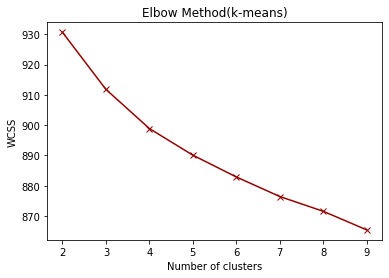

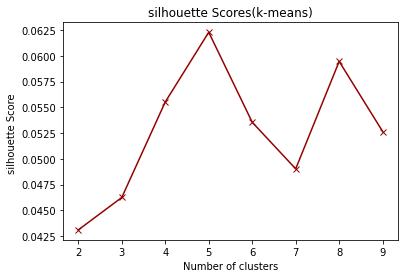

In [180]:
Choose_Best_K(X_Tf_IDF,2,10)

In [181]:
km =Kmeans(X_Tf_IDF,5)

Initialization complete
Iteration 0, inertia 1769.7464153986202
Iteration 1, inertia 905.0488586459842
Iteration 2, inertia 900.8761989622717
Iteration 3, inertia 898.2980282059974
Iteration 4, inertia 896.5993496981632
Iteration 5, inertia 895.8703348206376
Iteration 6, inertia 894.3456633021963
Iteration 7, inertia 891.7635965925532
Iteration 8, inertia 890.3007119734439
Iteration 9, inertia 890.213925863171
Iteration 10, inertia 890.1747935716851
Iteration 11, inertia 890.1624682359002
Iteration 12, inertia 890.1415455887043
Iteration 13, inertia 890.1315619202298
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 1760.3393822719852
Iteration 1, inertia 904.7464316943482
Iteration 2, inertia 897.5834051240206
Iteration 3, inertia 896.3609444717722
Iteration 4, inertia 895.8907438045143
Iteration 5, inertia 895.847544478076
Iteration 6, inertia 895.814138417104
Iteration 7, inertia 895.8019280302365
Iteration 8, inertia 895.7814313194094
Itera

Caculate Metrics 

In [182]:
#Map between Clusters and Books
Labels_TFIDF , MabDic= ReName_Clusters(km.labels_,Y)

Test_Models(X_Tf_IDF,Y,Labels_TFIDF)

(array([1, 3, 4]), array([ 19, 196,  19]))
(array([2]), array([200]))
(array([3, 4]), array([  4, 181]))
(array([1]), array([181]))
(array([0]), array([200]))
-------------------------------------
Homogeneity: 0.907
Completeness: 0.910
V-measure: 0.908
Adjusted Rand-Index: 0.899
Silhouette Coefficient: 0.062
Kappa: 0.948
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.078s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.587s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.505s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.505s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.481s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.478s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.392s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004466 (50 iterations in 0.384s)
[t-SNE] Iteration 400: error = 0.7682273, gradient norm

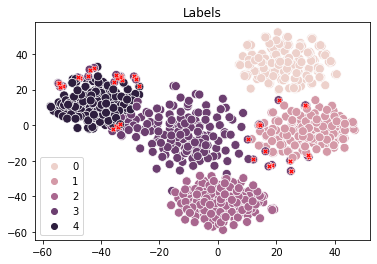

In [183]:
Visulaize_Data_With_WrongPoints(X_Tf_IDF,Labels_TFIDF, Y,"Labels")


## Kmean_BOW

Streaming output truncated to the last 5000 lines.
Iteration 12, inertia 255027.10734301055
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 543397.0
Iteration 1, inertia 255779.36016658263
Iteration 2, inertia 255160.44085045415
Iteration 3, inertia 255057.58765883895
Iteration 4, inertia 255028.68667255132
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 466241.0
Iteration 1, inertia 257407.51386390754
Iteration 2, inertia 255441.4088464858
Iteration 3, inertia 255149.22867812729
Iteration 4, inertia 255071.97604818136
Iteration 5, inertia 255033.17745051143
Iteration 6, inertia 255028.68667255132
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 441717.0
Iteration 1, inertia 258155.34656444547
Iteration 2, inertia 255832.1971343495
Iteration 3, inertia 255374.79695015002
Iteration 4, inertia 255154.27291406208
Iteration 5, inertia 255049.2879412425
Iteration 

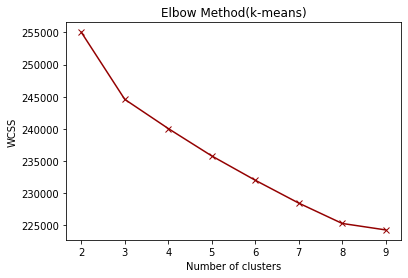

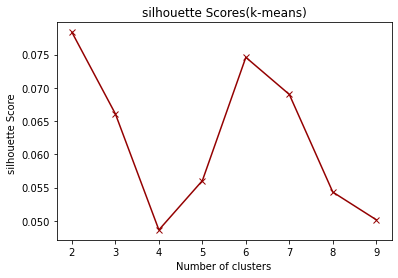

In [184]:
Choose_Best_K(X_Bow,2,10)

In [185]:
km =Kmeans(X_Bow,5)

Initialization complete
Iteration 0, inertia 418175.0
Iteration 1, inertia 244584.50921923795
Iteration 2, inertia 239836.14154961403
Iteration 3, inertia 238406.00700140218
Iteration 4, inertia 237682.92050545648
Iteration 5, inertia 237502.2887418292
Iteration 6, inertia 237455.78814438632
Iteration 7, inertia 237424.93644100847
Iteration 8, inertia 237420.7841410649
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 417829.0
Iteration 1, inertia 240898.9096687053
Iteration 2, inertia 237571.60589424855
Iteration 3, inertia 236928.20982998284
Iteration 4, inertia 236736.6745676567
Iteration 5, inertia 236708.14286499892
Iteration 6, inertia 236693.5167960561
Iteration 7, inertia 236687.85388577724
Iteration 8, inertia 236681.51417985663
Iteration 9, inertia 236679.85924619366
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 408565.0
Iteration 1, inertia 238713.45401443014
Iteration 2, inertia 237896.328

In [186]:
#Map between Clusters and Books
Labels , MabDic= ReName_Clusters(km.labels_,Y)

Test_Models(X_Bow,Y,Labels)

(array([3, 4]), array([ 3, 34]))
(array([1, 4]), array([161,   1]))
(array([3, 4]), array([  4, 131]))
(array([0, 1, 2, 3, 4]), array([ 13,  39, 200, 193,  34]))
(array([0]), array([187]))
-------------------------------------
Homogeneity: 0.615
Completeness: 0.783
V-measure: 0.689
Adjusted Rand-Index: 0.530
Silhouette Coefficient: 0.074
Kappa: 0.641
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.079s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.599s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.499s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.497s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.473s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.472s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.397s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004466 (50 iterations in 0.390s)
[t-SNE] Iteration 400: error = 0.7682273, gradient norm

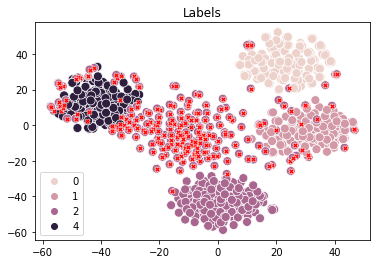

In [187]:
Visulaize_Data_With_WrongPoints(X_Tf_IDF,Labels, Y,"Labels")


## Kmean_2Gram

plot silhouette and WCSS to choose best K 

Initialization complete
Iteration 0, inertia 1988.255830140119
Iteration 1, inertia 994.8988451401431
Iteration 2, inertia 994.8851571099297
Iteration 3, inertia 994.8702164475842
Iteration 4, inertia 994.8503163507735
Iteration 5, inertia 994.8293804745193
Iteration 6, inertia 994.7929313091856
Iteration 7, inertia 994.7293992786643
Iteration 8, inertia 994.7023083838865
Iteration 9, inertia 994.6884047495278
Iteration 10, inertia 994.6703950150969
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 1984.383999080772
Iteration 1, inertia 995.0258285267536
Iteration 2, inertia 995.0208828615708
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1985.0426247109035
Iteration 1, inertia 994.9910512818683
Iteration 2, inertia 994.9840840761497
Iteration 3, inertia 994.9770771150118
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1984.8929683985054
Iteration 1, inertia 

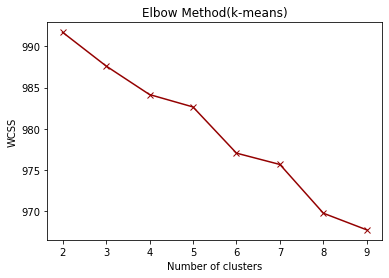

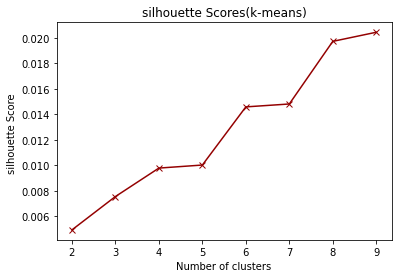

In [188]:
Choose_Best_K(X_2Gram,2,10)

In [189]:
km =Kmeans(X_2Gram,5)

Initialization complete
Iteration 0, inertia 1957.2890797595894
Iteration 1, inertia 986.414599719302
Iteration 2, inertia 985.4273816500773
Iteration 3, inertia 985.2227173115054
Iteration 4, inertia 985.0722684947398
Iteration 5, inertia 984.9162046172171
Iteration 6, inertia 984.873116363473
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1953.9491976850602
Iteration 1, inertia 984.5909429246751
Iteration 2, inertia 983.3557929589585
Iteration 3, inertia 982.8951318524163
Iteration 4, inertia 982.7864733629449
Iteration 5, inertia 982.7570688210294
Iteration 6, inertia 982.7375290716714
Iteration 7, inertia 982.7278095969373
Iteration 8, inertia 982.7180692690422
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 1956.6850175185991
Iteration 1, inertia 985.6494547905207
Iteration 2, inertia 984.5827323863502
Iteration 3, inertia 984.2604682202559
Iteration 4, inertia 984.1597488874789
Iteration 5, ine

Caculate Metrics 

In [190]:
#Map between Clusters and Books
Labels , MabDic= ReName_Clusters(km.labels_,Y)

Test_Models(X_2Gram,Y,Labels)

(array([1, 2, 3, 4]), array([  5,   3,  12, 136]))
(array([0, 1, 3, 4]), array([53, 18,  2,  4]))
(array([0, 1, 2]), array([45,  8,  6]))
(array([0, 1]), array([81,  3]))
(array([0, 1, 2, 3, 4]), array([ 21, 166, 191, 186,  60]))
-------------------------------------
Homogeneity: 0.314
Completeness: 0.551
V-measure: 0.400
Adjusted Rand-Index: 0.258
Silhouette Coefficient: 0.006
Kappa: 0.382
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.132779


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities in 0.094s
[t-SNE] Iteration 50: error = 65.2983856, gradient norm = 0.2679403 (50 iterations in 0.569s)
[t-SNE] Iteration 100: error = 65.2170334, gradient norm = 0.2795857 (50 iterations in 0.692s)
[t-SNE] Iteration 150: error = 65.1044159, gradient norm = 0.2663695 (50 iterations in 0.576s)
[t-SNE] Iteration 200: error = 64.9696655, gradient norm = 0.2716016 (50 iterations in 0.544s)
[t-SNE] Iteration 250: error = 65.2304916, gradient norm = 0.2697581 (50 iterations in 0.561s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.230492
[t-SNE] Iteration 300: error = 1.5253440, gradient norm = 0.0016829 (50 iterations in 0.412s)
[t-SNE] Iteration 350: error = 1.3600893, gradient norm = 0.0008143 (50 iterations in 0.414s)
[t-SNE] Iteration 400: error = 1.2886899, gradient norm = 0.0004744 (50 iterations in 0.397s)
[t-SNE] Iteration 450: error = 1.2635772, gradient norm = 0.0002522 (50 iterations in 0.411s)
[t-SNE] Iteration 5

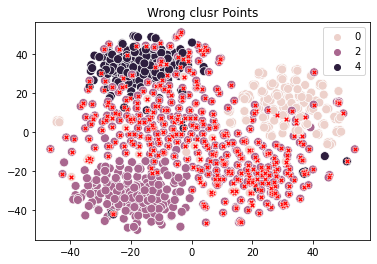

In [191]:
Visulaize_Data_With_WrongPoints(X_2Gram,Labels, Y,"Wrong clusr Points")


## Kmean_word2vec

plot silhouette and WCSS to choose best K 

Streaming output truncated to the last 5000 lines.
Iteration 3, inertia 6196.48828125
Iteration 4, inertia 6182.9658203125
Iteration 5, inertia 6178.94482421875
Iteration 6, inertia 6176.89453125
Iteration 7, inertia 6174.57763671875
Iteration 8, inertia 6172.25634765625
Iteration 9, inertia 6169.40673828125
Iteration 10, inertia 6168.44091796875
Iteration 11, inertia 6168.197265625
Iteration 12, inertia 6167.8779296875
Iteration 13, inertia 6167.7900390625
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 10783.62890625
Iteration 1, inertia 6452.328125
Iteration 2, inertia 6339.814453125
Iteration 3, inertia 6300.2900390625
Iteration 4, inertia 6287.30859375
Iteration 5, inertia 6281.9130859375
Iteration 6, inertia 6276.1435546875
Iteration 7, inertia 6271.955078125
Iteration 8, inertia 6269.220703125
Iteration 9, inertia 6267.1328125
Iteration 10, inertia 6265.1201171875
Iteration 11, inertia 6263.14306640625
Iteration 12, inertia 6262.262695

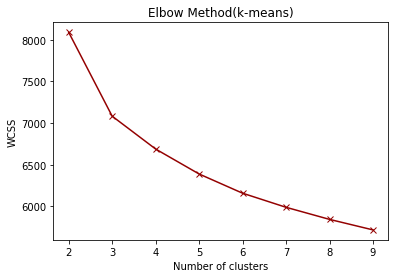

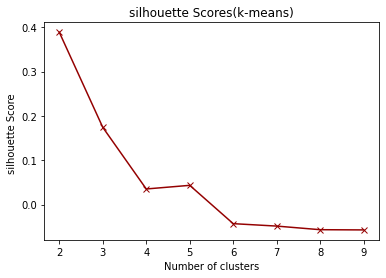

In [201]:
Choose_Best_K(word2vec,2,10)

In [202]:
km =Kmeans(word2vec,5)

Initialization complete
Iteration 0, inertia 11154.814453125
Iteration 1, inertia 6598.51025390625
Iteration 2, inertia 6448.56298828125
Iteration 3, inertia 6420.93359375
Iteration 4, inertia 6411.0869140625
Iteration 5, inertia 6406.69140625
Iteration 6, inertia 6403.92236328125
Iteration 7, inertia 6402.55908203125
Iteration 8, inertia 6402.0224609375
Iteration 9, inertia 6401.54296875
Iteration 10, inertia 6401.09765625
Iteration 11, inertia 6400.45751953125
Iteration 12, inertia 6399.5048828125
Iteration 13, inertia 6397.88671875
Iteration 14, inertia 6395.99169921875
Iteration 15, inertia 6394.76806640625
Iteration 16, inertia 6393.8544921875
Iteration 17, inertia 6393.3251953125
Iteration 18, inertia 6392.7685546875
Iteration 19, inertia 6392.197265625
Iteration 20, inertia 6391.7919921875
Iteration 21, inertia 6391.62646484375
Iteration 22, inertia 6391.55126953125
Iteration 23, inertia 6391.5029296875
Converged at iteration 23: strict convergence.
Initialization complete
Itera

Caculate Metrics 

In [203]:
word2vec.shape

(1000, 11422)

In [204]:
#Map between Clusters and Books
Labels , MabDic= ReName_Clusters(km.labels_,Y)

Test_Models(word2vec,Y,Labels)

(array([0, 1, 2, 3, 4]), array([45, 47, 40, 49, 49]))
(array([0, 1, 2, 3, 4]), array([32, 36, 32, 34, 31]))
(array([0, 1, 2, 3, 4]), array([52, 50, 56, 49, 48]))
(array([0, 1, 2, 3, 4]), array([45, 41, 41, 41, 47]))
(array([0, 1, 2, 3, 4]), array([26, 26, 31, 27, 25]))
-------------------------------------
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: -0.002
Silhouette Coefficient: 0.033
Kappa: 0.024
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 1.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.012751
[t-SNE] Computed conditional probabilities in 0.104s
[t-SNE] Iteration 50: error = 66.2017975, gradient norm = 0.2806602 (50 iterations in 0.541s)
[t-SNE] Iteration 100: error = 66.0528412, gradient norm = 0.2567228 (50 iterations in 0.555s)
[t-SNE] Iteration 150: error = 65.9426346, gradient norm = 0.2632685 (50 iterations in 0.513s)
[t-SNE] Iteration 200: error = 67.4169769, gradient norm = 0.2715651 (50 iterations in 0.597s)
[t-SNE] Iteration 250: error = 67.3106308, gradient norm = 0.2680054 (50 iterations in 0.508s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.310631
[t-SNE] Iteration 300: error = 1.3934157, gradient norm = 0.0027250 (50 iterations in 0.494s)
[t-SNE] Iteration 350: error = 1.3499660, gradient norm = 0.0004306 (50 iterations in 0.452s)
[t-SNE] Iteration 400: error = 1.3386123, gradient norm

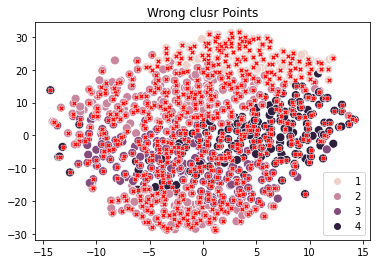

In [205]:
Visulaize_Data_With_WrongPoints(word2vec,Labels, Y,"Wrong clusr Points")


## LDA

Initialization complete
Iteration 0, inertia 459.9276428222656
Iteration 1, inertia 315.55328369140625
Iteration 2, inertia 315.3959045410156
Iteration 3, inertia 315.37969970703125
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 466.0291748046875
Iteration 1, inertia 301.0644836425781
Iteration 2, inertia 299.3095703125
Iteration 3, inertia 299.27313232421875
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 578.990478515625
Iteration 1, inertia 343.46197509765625
Iteration 2, inertia 333.9341735839844
Iteration 3, inertia 333.32806396484375
Iteration 4, inertia 333.2469177246094
Iteration 5, inertia 333.2325439453125
Iteration 6, inertia 333.207275390625
Iteration 7, inertia 333.190673828125
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 590.482421875
Iteration 1, inertia 350.5813903808594
Iteration 2, inertia 336.27313232421875
Iteration 3, inertia 333.5775

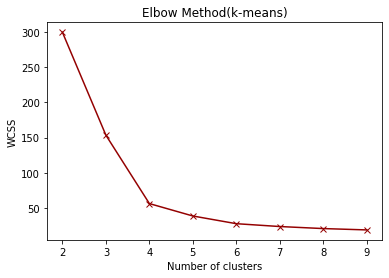

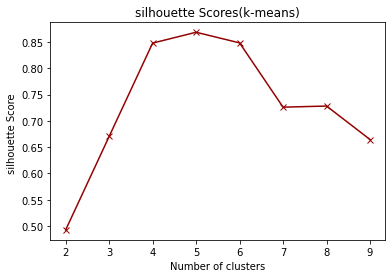

In [206]:
Choose_Best_K(lda_x,2,10)

In [207]:
km =Kmeans(lda_x,5)

Initialization complete
Iteration 0, inertia 64.1659164428711
Iteration 1, inertia 44.16998291015625
Iteration 2, inertia 43.82880401611328
Iteration 3, inertia 43.68409729003906
Iteration 4, inertia 43.62178421020508
Iteration 5, inertia 43.6170768737793
Iteration 6, inertia 43.60963821411133
Iteration 7, inertia 43.60575866699219
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 49.47186279296875
Iteration 1, inertia 40.39716339111328
Iteration 2, inertia 39.38994598388672
Iteration 3, inertia 38.92900085449219
Iteration 4, inertia 38.85271453857422
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 62.22637939453125
Iteration 1, inertia 39.26106643676758
Iteration 2, inertia 38.9358024597168
Iteration 3, inertia 38.90891647338867
Iteration 4, inertia 38.85271453857422
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 70.05675506591797
Iteration 1, inertia 51.6387

In [208]:
#Map between Clusters and Books
Labels , MabDic= ReName_Clusters(km.labels_,Y)

Test_Models(lda_x,Y,Labels)

(array([1, 3, 4]), array([  4, 138,   1]))
(array([0, 1]), array([196, 172]))
(array([1, 3, 4]), array([  3,   2, 199]))
(array([0, 2]), array([  4, 200]))
(array([1, 3]), array([21, 60]))
-------------------------------------
Homogeneity: 0.760
Completeness: 0.906
V-measure: 0.827
Adjusted Rand-Index: 0.739
Silhouette Coefficient: 0.832
Kappa: 0.741
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.043s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000035
[t-SNE] Computed conditional probabilities in 0.111s
[t-SNE] Iteration 50: error = 52.8041229, gradient norm = 0.2289270 (50 iterations in 0.475s)
[t-SNE] Iteration 100: error = 49.0420036, gradient norm = 0.1771988 (50 iterations in 0.372s)
[t-SNE] Iteration 150: error = 48.2043037, gradient norm = 0.1622544 (50 iterations in 0.395s)
[t-SNE] Iteration 200: error = 47.8733406, gradient norm = 0.1496522 (50 iterations in 0.377s)
[t-SNE] Iteration 250: error = 47.6652489, gradient norm = 0.1390276 (50 iterations in 0.362s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.665249
[t-SNE] Iteration 300: error = 0.3437031, gradient norm = 0.0006343 (50 iterations in 0.347s)
[t-SNE] Iteration 350: error = 0.2898971, gradient norm = 0.0002463 (50 iterations in 0.362s)
[t-SNE] Iteration 400: error = 0.2788859, gradient norm = 0.0001870 (50 iterations in 0.342s)
[t-SNE] Iteration 

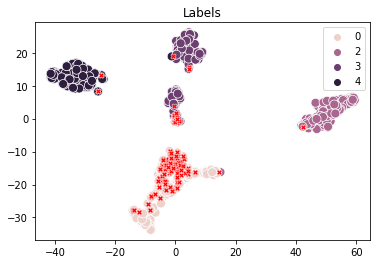

In [209]:
Visulaize_Data_With_WrongPoints(lda_x,Labels, Y,"Labels")


# Hierarchical 

In [210]:
import scipy.cluster.hierarchy as sch

## TF_IDF

In [211]:
hirichiral = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')

In [212]:
hirichiral_TF = hirichiral.fit_predict(X_Tf_IDF.toarray())

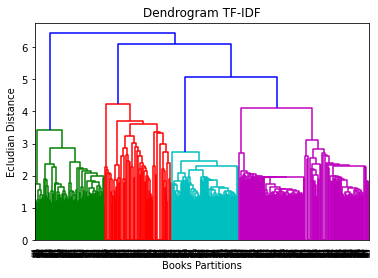

In [213]:
plt_dendrogram = sch.dendrogram(sch.linkage(X_Tf_IDF.toarray(),method = 'ward'))
plt.title("Dendrogram TF-IDF")
plt.xlabel('Books Partitions')
plt.ylabel('Ecludian Distance')
plt.show()

In [214]:
Labels , MabDic= ReName_Clusters(hirichiral_TF,Y)

(array([0, 1, 3, 4]), array([  2, 200, 188,   1]))
(array([3, 4]), array([ 10, 199]))
(array([0, 3]), array([172,   2]))
(array([2]), array([200]))
(array([0]), array([26]))


In [215]:
Test_Models(X_Tf_IDF,Y,Labels)

-------------------------------------
Homogeneity: 0.789
Completeness: 0.949
V-measure: 0.862
Adjusted Rand-Index: 0.759
Silhouette Coefficient: 0.056
Kappa: 0.746
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.305632
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 64.9016266, gradient norm = 0.2612475 (50 iterations in 0.568s)
[t-SNE] Iteration 100: error = 63.7746277, gradient norm = 0.2486960 (50 iterations in 0.524s)
[t-SNE] Iteration 150: error = 63.4124451, gradient norm = 0.2568580 (50 iterations in 0.474s)
[t-SNE] Iteration 200: error = 64.3768158, gradient norm = 0.2422771 (50 iterations in 0.476s)
[t-SNE] Iteration 250: error = 63.6461411, gradient norm = 0.2480476 (50 iterations in 0.485s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.646141
[t-SNE] Iteration 300: error = 0.9288201, gradient norm = 0.0019864 (50 iterations in 0.399s)
[t-SNE] Iteration 350: error = 0.8083191, gradient norm = 0.0004466 (50 iterations in 0.389s)
[t-SNE] Iteration 400: error = 0.7682273, gradient norm

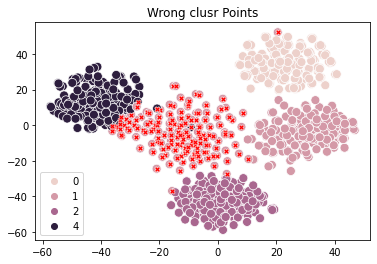

In [216]:
Visulaize_Data_With_WrongPoints(X_Tf_IDF,Labels, Y,"Wrong clusr Points")

## BOW

In [217]:
hirichiral = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')

In [218]:
hirichiral_TF = hirichiral.fit_predict(X_Bow.toarray())

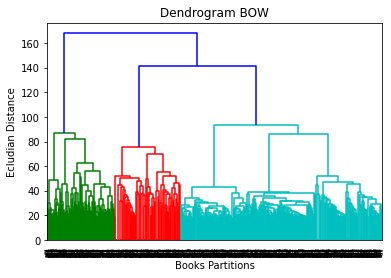

In [219]:
plt_dendrogram = sch.dendrogram(sch.linkage(X_Bow.toarray(),method = 'ward'))
plt.title("Dendrogram BOW")
plt.xlabel('Books Partitions')
plt.ylabel('Ecludian Distance')
plt.show()

In [220]:
Labels , MabDic= ReName_Clusters(hirichiral_TF,Y)


(array([0, 1, 2, 3, 4]), array([  2, 200,   4, 191,   6]))
(array([3, 4]), array([  8, 153]))
(array([0, 4]), array([196,   1]))
(array([0, 2]), array([  2, 196]))
(array([3, 4]), array([ 1, 40]))


In [221]:
Test_Models(X_Bow,Y,Labels)

-------------------------------------
Homogeneity: 0.757
Completeness: 0.916
V-measure: 0.829
Adjusted Rand-Index: 0.728
Silhouette Coefficient: 0.083
Kappa: 0.731
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1000 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.172031
[t-SNE] Computed conditional probabilities in 0.091s
[t-SNE] Iteration 50: error = 69.2466278, gradient norm = 0.3138098 (50 iterations in 0.589s)
[t-SNE] Iteration 100: error = 70.0429535, gradient norm = 0.2746904 (50 iterations in 0.552s)
[t-SNE] Iteration 150: error = 69.9708481, gradient norm = 0.2696222 (50 iterations in 0.545s)
[t-SNE] Iteration 200: error = 71.2942123, gradient norm = 0.2569817 (50 iterations in 0.543s)
[t-SNE] Iteration 250: error = 68.9286652, gradient norm = 0.2857198 (50 iterations in 0.573s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.928665
[t-SNE] Iteration 300: error = 0.9880929, gradient norm = 0.0016707 (50 iterations in 0.422s)
[t-SNE] Iteration 350: error = 0.8913491, gradient norm = 0.0004599 (50 iterations in 0.408s)
[t-SNE] Iteration 400: error = 0.8582976, gradient norm

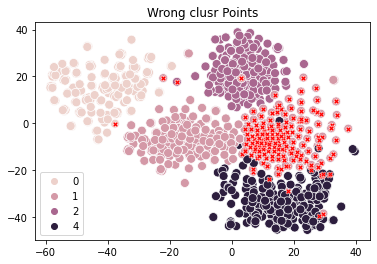

In [222]:
Visulaize_Data_With_WrongPoints(X_Bow,Labels, Y,"Wrong clusr Points")

## LDA

In [223]:
hirichiral = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')

In [224]:
hirichiral_TF = hirichiral.fit_predict(lda_x)

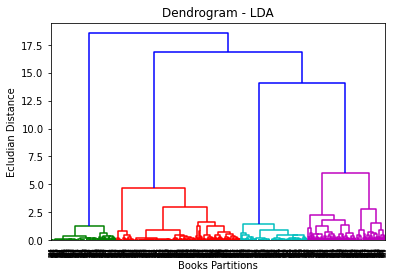

In [225]:
plt_dendrogram = sch.dendrogram(sch.linkage(lda_x,method = 'ward'))
plt.title("Dendrogram - LDA")
plt.xlabel('Books Partitions')
plt.ylabel('Ecludian Distance')
plt.show()

In [226]:
#Map between Clusters and Books
Labels , MabDic= ReName_Clusters(hirichiral_TF,Y)

Test_Models(lda_x,Y,Labels)

(array([0, 1, 2]), array([197, 173,   1]))
(array([3, 4]), array([141,   4]))
(array([1, 3]), array([27, 59]))
(array([4]), array([196]))
(array([0, 2]), array([  3, 199]))
-------------------------------------
Homogeneity: 0.763
Completeness: 0.911
V-measure: 0.830
Adjusted Rand-Index: 0.736
Silhouette Coefficient: 0.810
Kappa: 0.740
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000035
[t-SNE] Computed conditional probabilities in 0.117s
[t-SNE] Iteration 50: error = 52.8041229, gradient norm = 0.2289270 (50 iterations in 0.456s)
[t-SNE] Iteration 100: error = 49.0420036, gradient norm = 0.1771988 (50 iterations in 0.391s)
[t-SNE] Iteration 150: error = 48.2043037, gradient norm = 0.1622544 (50 iterations in 0.363s)
[t-SNE] Iteration 200: error = 47.8733406, gradient norm = 0.1496522 (50 iterations in 0.351s)
[t-SNE] Iteration 250: error = 47.6652489, gradient norm = 0.1390276 (50 iterations in 0.365s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.665249
[t-SNE] Iteration 300: error = 0.3437031, gradient norm = 0.0006343 (50 iterations in 0.338s)
[t-SNE] Iteration 350: error = 0.2898971, gradient norm = 0.0002463 (50 iterations in 0.342s)
[t-SNE] Iteration 400: error = 0.2788859, gradient norm = 0.0001870 (50 iterations in 0.365s)
[t-SNE] Iteration 

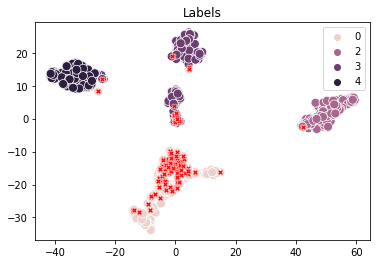

In [227]:
Visulaize_Data_With_WrongPoints(lda_x,Labels, Y,"Labels")

# EM

## TF_IDF

In [228]:
from sklearn.mixture import GaussianMixture

In [229]:
gmm = GaussianMixture(n_components=5,random_state=6)
em_labels = gmm.fit_predict(X_SVD_Tf_idf)

In [230]:
Labels_ME_TF_IDF , MabDic= ReName_Clusters(em_labels,Y)

(array([1, 3, 4]), array([200, 190,   8]))
(array([0]), array([112]))
(array([0]), array([88]))
(array([2]), array([200]))
(array([3, 4]), array([ 10, 192]))


In [231]:
Test_Models(X_SVD_Tf_idf,Y,Labels_ME_TF_IDF)

-------------------------------------
Homogeneity: 0.783
Completeness: 0.945
V-measure: 0.856
Adjusted Rand-Index: 0.746
Silhouette Coefficient: 0.057
Kappa: 0.740
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.082s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.309266
[t-SNE] Computed conditional probabilities in 0.132s
[t-SNE] Iteration 50: error = 68.6885834, gradient norm = 0.2403896 (50 iterations in 0.522s)
[t-SNE] Iteration 100: error = 66.4081879, gradient norm = 0.2441199 (50 iterations in 0.490s)
[t-SNE] Iteration 150: error = 65.8570557, gradient norm = 0.2525098 (50 iterations in 0.485s)
[t-SNE] Iteration 200: error = 66.9271698, gradient norm = 0.2513282 (50 iterations in 0.498s)
[t-SNE] Iteration 250: error = 67.6240234, gradient norm = 0.2195332 (50 iterations in 0.467s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.624023
[t-SNE] Iteration 300: error = 0.9854008, gradient norm = 0.0034567 (50 iterations in 0.428s)
[t-SNE] Iteration 350: error = 0.8760772, gradient norm = 0.0005092 (50 iterations in 0.372s)
[t-SNE] Iteration 400: error = 0.8310733, gradient norm = 0.0003270 (50 iterations in 0.393s)
[t-SNE] Iteration 

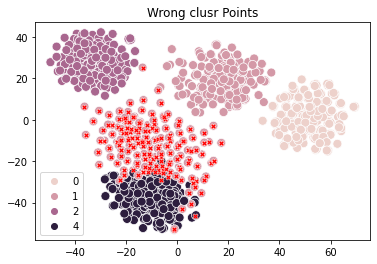

In [232]:
Visulaize_Data_With_WrongPoints(X_SVD_Tf_idf,Labels_ME_TF_IDF, Y,"Wrong clusr Points")

## BOW

In [233]:
gmm = GaussianMixture(n_components=5)
em_labels = gmm.fit_predict(X_SVD_Bow)

In [234]:
Labels , MabDic= ReName_Clusters(em_labels,Y)

(array([3, 4]), array([  5, 170]))
(array([0, 4]), array([159,   1]))
(array([0]), array([28]))
(array([1]), array([179]))
(array([0, 1, 2, 3, 4]), array([ 13,  21, 200, 195,  29]))


In [235]:
Test_Models(X_SVD_Bow,Y,Labels)

-------------------------------------
Homogeneity: 0.657
Completeness: 0.823
V-measure: 0.731
Adjusted Rand-Index: 0.591
Silhouette Coefficient: 0.077
Kappa: 0.670
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.076s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.194838
[t-SNE] Computed conditional probabilities in 0.139s
[t-SNE] Iteration 50: error = 68.2344208, gradient norm = 0.3167587 (50 iterations in 0.565s)
[t-SNE] Iteration 100: error = 69.9509964, gradient norm = 0.2855512 (50 iterations in 0.541s)
[t-SNE] Iteration 150: error = 71.2087708, gradient norm = 0.2508889 (50 iterations in 0.511s)
[t-SNE] Iteration 200: error = 70.9080582, gradient norm = 0.2718468 (50 iterations in 0.575s)
[t-SNE] Iteration 250: error = 70.4084015, gradient norm = 0.2789176 (50 iterations in 0.529s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.408401
[t-SNE] Iteration 300: error = 1.0456951, gradient norm = 0.0023214 (50 iterations in 0.573s)
[t-SNE] Iteration 350: error = 0.9177620, gradient norm = 0.0005870 (50 iterations in 0.450s)
[t-SNE] Iteration 400: error = 0.8811498, gradient norm = 0.0002613 (50 iterations in 0.469s)
[t-SNE] Iteration 

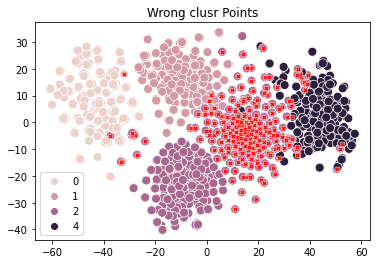

In [236]:
Visulaize_Data_With_WrongPoints(X_SVD_Bow,Labels, Y,"Wrong clusr Points")

## LDA

In [237]:
gmm = GaussianMixture(n_components=5)
em_labels = gmm.fit_predict(lda_x)

In [238]:
Labels , MabDic= ReName_Clusters(em_labels,Y)

(array([0, 1, 2]), array([174,  32, 104]))
(array([4]), array([149]))
(array([1, 2, 3, 4]), array([  3,   2, 142,  51]))
(array([0, 2]), array([ 1, 94]))
(array([0, 1, 3]), array([ 25, 165,  58]))


In [239]:
Test_Models(lda_x,Y,Labels)

-------------------------------------
Homogeneity: 0.603
Completeness: 0.631
V-measure: 0.617
Adjusted Rand-Index: 0.482
Silhouette Coefficient: 0.191
Kappa: 0.655
-------------------------------------


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.040s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000035
[t-SNE] Computed conditional probabilities in 0.118s
[t-SNE] Iteration 50: error = 52.8041229, gradient norm = 0.2289270 (50 iterations in 0.473s)
[t-SNE] Iteration 100: error = 49.0420036, gradient norm = 0.1771988 (50 iterations in 0.361s)
[t-SNE] Iteration 150: error = 48.2043037, gradient norm = 0.1622544 (50 iterations in 0.375s)
[t-SNE] Iteration 200: error = 47.8733406, gradient norm = 0.1496522 (50 iterations in 0.403s)
[t-SNE] Iteration 250: error = 47.6652489, gradient norm = 0.1390276 (50 iterations in 0.353s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.665249
[t-SNE] Iteration 300: error = 0.3437031, gradient norm = 0.0006343 (50 iterations in 0.339s)
[t-SNE] Iteration 350: error = 0.2898971, gradient norm = 0.0002463 (50 iterations in 0.343s)
[t-SNE] Iteration 400: error = 0.2788859, gradient norm = 0.0001870 (50 iterations in 0.346s)
[t-SNE] Iteration 

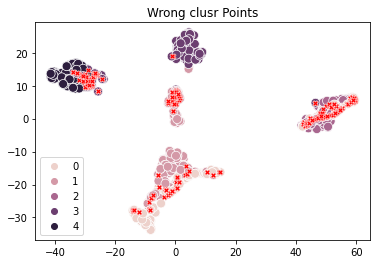

In [240]:
Visulaize_Data_With_WrongPoints(lda_x,Labels, Y,"Wrong clusr Points")

# Error analysis

WE choosed ME with TF_IDF Data as champion Model


WE will see frequnt words that make the model off

Number of Wrong points 42


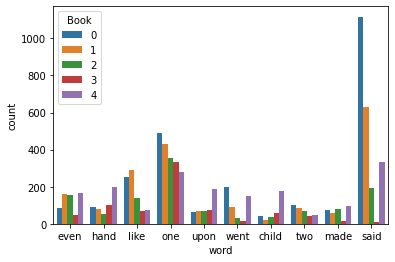

In [241]:
Error_any( X_Tf_IDF,Transformer_TDIDF, Labels_TFIDF ,Y )